# Pedestrian simulation of planet gravitational dynamics

In [58]:
import math
from typing import List
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [18, 12]
import timeit
from IPython.display import clear_output

colors = ['g-', 'r-', 'b-', 'y-', 'g-', 'b-']

### A few useful constants

In [59]:
M_earth = 5.972 * (10.0 ** 24)  # in kg
R_earth: float = 6.371 * (10.0 ** 6)  # in m
M_sun = 1.989 * (10.0 ** 30)  # in kg
R_sun = 6.9551 * (10.0 ** 8)  # in m
D_earth_sun = 1.4714 * (10.0 ** 11)  # in m
D_earth_moon = 3.844 * (10.0 ** 8)  # in m
V_earth = 30000.0  # in m/s
G = 6.67408 * (10.0 ** -11.0)  # gravitational constant, in m^3 / (kg * s^2)

days_to_sec = 24.0 * 60.0 * 60.0
days_to_years = 1.0 / 365.25

### Plotting helpers

In [60]:

def compute_plot_limits(planets, dim, current_lim_min=0.0, current_lim_plus=0.0):
    n = len(planets)
    i = 0
    lim_plus = current_lim_plus
    lim_min = current_lim_min
    while i < n:
        p = planets[i]
        if dim == 1:
            if p.x > 0.0:
                lim_plus = max(lim_plus, p.x)
            else:
                lim_min = min(lim_min, p.x)
        elif dim == 2:
            if p.y > 0.0:
                lim_plus = max(lim_plus, p.y)
            else:
                lim_min = min(lim_min, p.y)
        elif dim == 3:
            if p.z > 0.0:
                lim_plus = max(lim_plus, p.z)
            else:
                lim_min = min(lim_min, p.z)
        i += 1
    return (min(lim_min, -R_earth), max(lim_plus, R_earth))


def set_up_plot(x, y, z, planets):
    lim_x_min, lim_x_plus = compute_plot_limits(planets, 1)
    lim_y_min, lim_y_plus = compute_plot_limits(planets, 2)
    lim_z_min, lim_z_plus = compute_plot_limits(planets, 3)

    fig = plt.figure()
    fig.add_subplot(1, 1, 1, projection='3d')
    axes = plt.gca(projection='3d')
    axes.set_xlim(lim_x_min, lim_x_plus)
    axes.set_ylim(lim_y_min, lim_y_plus)
    axes.set_zlim(lim_z_min, lim_z_plus)

    plt.title("T=0 years")
    axes.set_xlabel("x")
    axes.set_ylabel("y")
    axes.set_zlabel("z")

    i = 0
    while i < len(planets):
        axes.plot(x[i], y[i], z[i], colors[i])
        i += 1
    plt.show()

    
def update_plot(x, y, z, planets, t):
    clear_output(wait=True)
    
    axes = plt.gca(projection='3d')
    i = 0
    while i < len(planets):
        axes.plot(x[i], y[i], z[i], colors[i])
        i += 1
        
    current_lim_x = axes.get_xlim()  # returns 2-tuple
    current_lim_y = axes.get_ylim()  # returns 2-tuple
    current_lim_z = axes.get_zlim()  # returns 2-tuple
    lim_x_min, lim_x_plus = compute_plot_limits(planets, 1, current_lim_x[0], current_lim_x[1])
    lim_y_min, lim_y_plus = compute_plot_limits(planets, 2, current_lim_y[0], current_lim_y[1])
    lim_z_min, lim_z_plus = compute_plot_limits(planets, 3, current_lim_z[0], current_lim_z[1])
    axes.set_xlim(lim_x_min, lim_x_plus)
    axes.set_ylim(lim_y_min, lim_y_plus)
    axes.set_zlim(lim_z_min, lim_z_plus)

    new_title = "T=" + str("%.2f" % t) + " years"
    plt.title(new_title)
    plt.show()

### Definition of a planet and other helper functions

In [61]:

class planet(object):
    def __init__(self,
                 name,
                 radius=1.0,
                 mass=1.0,
                 x=0., y=0., z=0.,
                 x_v=0., y_v=0., z_v=0.,
                 x_a=0., y_a=0., z_a=0.):
        self.name = name
        self.radius = radius
        self.mass = mass
        self.x = x
        self.y = y
        self.z = z
        self.x_v = x_v
        self.y_v = y_v
        self.z_v = z_v
        self.x_a = x_a
        self.y_a = y_a
        self.z_a = z_a

    def volume(self) -> float:
        return (4.0 / 3.0) * math.pi * (self.radius ** 3.0)

    def density(self) -> float:
        return self.mass / self.volume()

    def update_position(self, delta_t):
        self.x += self.x_v * delta_t
        self.y += self.y_v * delta_t
        self.z += self.z_v * delta_t

    def update_velocity(self, delta_t):
        self.x_v += self.x_a * delta_t
        self.y_v += self.y_a * delta_t
        self.z_v += self.z_a * delta_t

    def clear_acceleration(self) -> object:
        self.x_a = 0.0
        self.y_a = 0.0
        self.z_a = 0.0

    def append_acceleration(self, dx_a, dy_a, dz_a):
        self.x_a += dx_a
        self.y_a += dy_a
        self.z_a += dz_a

    def report(self):
        print("Planet", self.name, ", mass %.2f, radius %.2f" % (self.mass, self.radius), ":")
        print("    * position:     ( %.2f, %.2f, %.2f)" % (self.x, self.y, self.z))
        print("    * velocity:     ( %.2f, %.2f, %.2f)" % (self.x_v, self.y_v, self.z_v))
        print("    * acceleration: ( %.2f, %.2f, %.2f)" % (self.x_a, self.y_a, self.z_a))


def set_up_positions(x, y, z, n):
    i = 0
    while i < n:
        x.append([])
        y.append([])
        z.append([])
        i += 1


def append_positions(x, y, z, planets):
    n = len(planets)
    i = 0
    while i < n:
        p = planets[i]
        x[i].append(p.x)
        y[i].append(p.y)
        z[i].append(p.z)
        i += 1


def distance_between_planets(p_lhs, p_rhs) -> float:
    return math.sqrt((p_lhs.x - p_rhs.x) ** 2.0 +
                     (p_lhs.y - p_rhs.y) ** 2.0 +
                     (p_lhs.z - p_rhs.z) ** 2.0)


def ran():
    return -1.0 + 2.0 * np.random.random()


def random_sun(name):
    return planet(name,
                  R_sun,  # radius
                  M_sun,  # mass
                  ran() * D_earth_sun, ran() * D_earth_sun, ran() * D_earth_sun,  # position
                  ran() * V_earth, ran() * V_earth, ran() * V_earth)  # velocity


def static_sun(name):
    return planet(name,
                  R_sun,  # radius
                  M_sun,  # mass
                  0.0, 0.0, 0.0,  # position
                  0.0, 0.0, 0.0)  # velocity


def random_earth(name):
    return planet(name,
                  R_earth,  # radius
                  M_earth,  # mass
                  ran() * D_earth_sun, ran() * D_earth_sun, ran() * D_earth_sun,  # position
                  ran() * V_earth, ran() * V_earth, ran() * V_earth)  # velocity


def static_earth(name):
    return planet(name,
                  R_earth,  # radius
                  M_earth,  # mass
                  0.0, 0.0, 0.0,  # position
                  0.0, 0.0, 0.0)  # velocity


### Physics

In [62]:
def gravitational_force(p1, p2):
    d = distance_between_planets(p1, p2)
    f = G * p1.mass * p2.mass / (d * d)
    return f


def gravitational_acceleration(f, p):
    return (f / p.mass) ** 0.5


def compute_accelerations(planets: List[planet]):
    n = len(planets)

    i = 0
    while i < n:
        planets[i].clear_acceleration()
        i += 1

    i_lhs = 0
    while i_lhs < n - 1:
        p_lhs = planets[i_lhs]
        i_rhs = i_lhs + 1
        while i_rhs < n:
            p_rhs = planets[i_rhs]
            f = gravitational_force(p_lhs, p_rhs)  # absolute force
            a_lhs = gravitational_acceleration(f, p_lhs)  # absolute acceleration on p_lhs
            a_rhs = gravitational_acceleration(f, p_rhs)  # absolute acceleration on p_rhs
            d = distance_between_planets(p_lhs, p_rhs)
            one_over_d = 1.0 / d
            d_x = p_rhs.x - p_lhs.x
            d_y = p_rhs.y - p_lhs.y
            d_z = p_rhs.z - p_lhs.z
            planets[i_lhs].append_acceleration(a_lhs * d_x * one_over_d, a_lhs * d_y * one_over_d, a_lhs * d_z * one_over_d)
            planets[i_rhs].append_acceleration(-a_rhs * d_x * one_over_d, -a_rhs * d_y * one_over_d, -a_rhs * d_z * one_over_d)
            i_rhs += 1
        i_lhs += 1
    return 0


### Time loop

In [63]:

# Horizon is on years, step is in days
def planet_dynamics(horizon, step, planets, dynamic_plot):
    delta_in_sec = step * days_to_sec

    x, y, z = [[]], [[]], [[]]
    set_up_positions(x, y, z, len(planets))
    set_up_plot(x, y, z, planets)

    total_time = 0  # in years
    while total_time <= horizon :

        #print("Time (in y): ", total_time, " --- Number of planets: ", len(planets))

        # print out the current positions of the planets
        #for p in planets:
        #    p.report()
        
        append_positions(x, y, z, planets)
        if dynamic_plot is True:
            update_plot(x, y, z, planets, total_time)

        compute_accelerations(planets)
        for p in planets:
            p.update_velocity(delta_in_sec)
            p.update_position(delta_in_sec)

        total_time += step * days_to_years  # in years
    
    update_plot(x, y, z, planets, total_time)

### This is where the fun begins
### Select your planets, your time horizon and your time step, an enjoy!

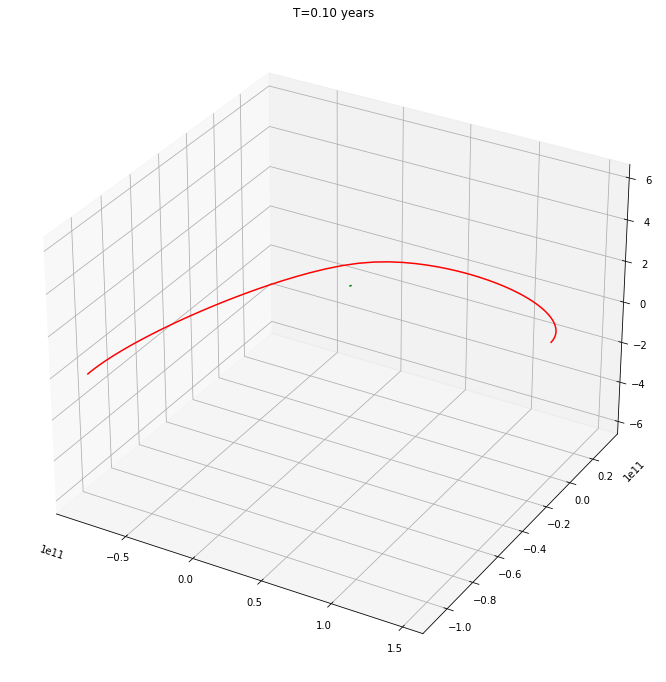

Time:  28.38 s


In [64]:
time_horizon = .1  # in years
time_delta = 0.5  # in days
# substantially slower, but much cooler! 
# I could not find a quick way to dynamically update the plot
dynamic_plot = True 

# define your planets here
planets = [static_sun("1"),
           planet("2", R_sun, M_earth, D_earth_sun, 0.0, 0.0, 0.0, V_earth, 0.0)]
    
start = timeit.default_timer()
planet_dynamics(time_horizon, time_delta, planets, dynamic_plot)
stop = timeit.default_timer()
print("Time: % 5.2f s" %(stop - start)) 